In [2]:
pip install gensim

  Stored in directory: C:\Users\Faizan\AppData\Local\pip\Cache\wheels\ab\10\93\5cff86f5b721d77edaecc29959b1c60d894be1f66d91407d28
Successfully built smart-open
Note: you may need to restart the kernel to use updated packages.


In [21]:
import logging
import pandas as pd
import numpy as np
from numpy import random
import gensim
import nltk
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics import accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
import re
from bs4 import BeautifulSoup
%matplotlib inline

In [4]:
data = pd.read_csv('Partial Preprocessed articles.csv')

In [69]:
data.shape

(15555, 10)

In [67]:
df1 = data[pd.notnull(data['label'])]


In [68]:
df1.shape

(15555, 10)

In [5]:
data.head()

,Unnamed: 0,claim,claimant,date,id,label,related_articles,articles_len,preprocessed_articles,all_preprocessed_articles
0,0,A line from George Orwell's novel 1984 predict...,NaN,2017-07-17,0,0,"[122094, 122580, 130685, 134765]",4,1984 george orwell predicted 2017 almost 70 y...,1984 george orwell predicted 2017 almost 70 y...
1,1,Maine legislature candidate Leslie Gibson insu...,NaN,2018-03-17,1,2,"[106868, 127320, 128060]",3,republican criticized parkland students drops ...,republican criticized parkland students drops ...
2,2,A 17-year-old girl named Alyssa Carson is bein...,NaN,2018-07-18,4,1,"[132130, 132132, 149722]",3,first person complete nasas passport program a...,first person complete nasas passport program a...
3,3,In 1988 author Roald Dahl penned an open lette...,NaN,2019-02-04,5,2,"[123254, 123418, 127464]",3,dangerous measles tweet 27 march 2013 many pa...,dangerous measles tweet 27 march 2013 many pa...
4,4,"When it comes to fighting terrorism, ""Another ...",Hillary Clinton,2016-03-22,6,2,"[41099, 89899, 72543, 82644, 95344, 88361]",6,remarks counterterrorism stanford university s...,remarks counterterrorism stanford university s...


In [6]:
data.claim.values

array(["A line from George Orwell's novel 1984 predicts the power of smartphones.",
       'Maine legislature candidate Leslie Gibson insulted Parkland shooting survivor and activist Emma Gonzalez via Twitter.',
       'A 17-year-old girl named Alyssa Carson is being trained by NASA to become an astronaut.',
       ...,
       '"We were not, I repeat, were not told that waterboarding or any of these other enhanced interrogation methods were used."',
       'As of August 2017, members of the public could potentially gain compensation as part of a class action lawsuit against major cruise companies.',
       '"We don\'t get any of that information" from the federal government on who refugees are, where they come from and how long they are likely to stay.'],
      dtype=object)

In [8]:
data.preprocessed_articles[0]

'1984  george orwell predicted 2017 almost 70 years ago april  1984  13 00  comrade 6079  winston smith  thinks thought  starts diary  falls love  big brother always watching  set world invasive government keeps malevolently watchful eye citizens  radical much lauded staging explores surveillance  identity orwell vision future relevant ever  brand new australian cast  bring adapter directors robert icke duncan macmillan thrilling vision back australia national tour  crystal ball  religious apparitions voices dead george orwell wrote nineteen eighty four  accurately depicted present almost 70 years ago  coincidence orwells 1949 novel climbed back multiple bestseller lists year  people realised scarily accurate foretelling  2013 relevance  still strong worryingly reliable  led west end smash hit adaptation book  currently showing australia  book one greatest dystopian novels every written  looks future people controlled think  act live government known big brother  uses telescreens  fear

In [9]:
df = pd.DataFrame()

In [10]:
df.loc[:,'Text'] = data.claim + data.preprocessed_articles 

In [11]:
df.loc[:, 'Label'] = data.label

In [14]:
df.Text[0]

"A line from George Orwell's novel 1984 predicts the power of smartphones.1984  george orwell predicted 2017 almost 70 years ago april  1984  13 00  comrade 6079  winston smith  thinks thought  starts diary  falls love  big brother always watching  set world invasive government keeps malevolently watchful eye citizens  radical much lauded staging explores surveillance  identity orwell vision future relevant ever  brand new australian cast  bring adapter directors robert icke duncan macmillan thrilling vision back australia national tour  crystal ball  religious apparitions voices dead george orwell wrote nineteen eighty four  accurately depicted present almost 70 years ago  coincidence orwells 1949 novel climbed back multiple bestseller lists year  people realised scarily accurate foretelling  2013 relevance  still strong worryingly reliable  led west end smash hit adaptation book  currently showing australia  book one greatest dystopian novels every written  looks future people contro

In [12]:
from sklearn.preprocessing import LabelEncoder

In [16]:
df2 = pd.DataFrame()
df2["Text"] = df["Text"]
df2["Label"] = df["Label"]
df2 = df2
print(df2.Text[5])
print(df2.head)
print(df2.shape)

Rhode Island is "almost dead last" among Northeastern states in the length of time first-degree murderers must spend in prison before they’re eligible for parole.lis   code virginia   18 2 10 prev   next  18 2 10  punishment conviction felony  penalty  authorized punishments conviction felony class 1 felonies  death  person convicted 18 years age older time offense determined mentally retarded pursuant 19 2 264 3 1 1  imprisonment life subject subdivision  g   fine 100 000  person 18 years age time offense determined mentally retarded pursuant 19 2 264 3 1 1  punishment shall imprisonment life subject subdivision  g   fine 100 000   b  class 2 felonies  imprisonment life term less 20 years subject subdivision  g   fine 100 000   c  class 3 felonies  term imprisonment less five years 20 years subject subdivision  g   fine 100 000   class 4 felonies  term imprisonment less two years 10 years subject subdivision  g   fine 100 000   e  class 5 felonies  term imprisonment less one year 10 y

In [74]:
df2.Label.unique()

array([0, 2, 1], dtype=int64)

In [75]:
df2.Label.isnull().sum()

0

In [17]:
REPLACE_BY_SPACE_RE = re.compile('[/(){}\[\]\|@,;]')
BAD_SYMBOLS_RE = re.compile('[^0-9a-z #+_]')
STOPWORDS = set(stopwords.words('english'))

def clean_text(text):
    """
        text: a string
        
        return: modified initial string
    """
    text = BeautifulSoup(text, "lxml").text # HTML decoding
    text = text.lower() # lowercase text
    text = REPLACE_BY_SPACE_RE.sub(' ', text) # replace REPLACE_BY_SPACE_RE symbols by space in text
    text = BAD_SYMBOLS_RE.sub('', text) # delete symbols which are in BAD_SYMBOLS_RE from text
    text = ' '.join(word for word in text.split() if word not in STOPWORDS) # delete stopwors from text
    return text
    
df2['Text'] = df2['Text'].apply(clean_text)

In [18]:
print(df2.Text[0])
print(df2.head)
print(df2.shape)

line george orwells novel 1984 predicts power smartphones1984 george orwell predicted 2017 almost 70 years ago april 1984 13 00 comrade 6079 winston smith thinks thought starts diary falls love big brother always watching set world invasive government keeps malevolently watchful eye citizens radical much lauded staging explores surveillance identity orwell vision future relevant ever brand new australian cast bring adapter directors robert icke duncan macmillan thrilling vision back australia national tour crystal ball religious apparitions voices dead george orwell wrote nineteen eighty four accurately depicted present almost 70 years ago coincidence orwells 1949 novel climbed back multiple bestseller lists year people realised scarily accurate foretelling 2013 relevance still strong worryingly reliable led west end smash hit adaptation book currently showing australia book one greatest dystopian novels every written looks future people controlled think act live government known big b

In [22]:
df2['Label'].value_counts().sort_values(ascending=False) #.iplot(kind='bar', yTitle='Number of Complaints', 
                                                                #title='Number complaints in each product')

0    7408
1    6451
2    1696
Name: Label, dtype: int64

In [20]:
#df = pd.read_csv('stack-overflow-data.csv')
#df = df[pd.notnull(df['tags'])]
#print(df.head(10))
print(df2['Text'].apply(lambda x: len(x.split(' '))).sum())

59922689


In [40]:
print(df2['Text'].apply(lambda x: len(x.split(' '))).mean())

3852.3104468016713


In [41]:
print(df2['Text'].apply(lambda x: len(x.split(' '))).max())

103432


In [42]:
print(df2['Text'].apply(lambda x: len(x.split(' '))).min())

15


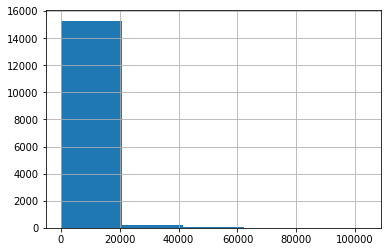

In [47]:
df2['Text'].apply(lambda x: len(x.split(' '))).hist(bins = 5)

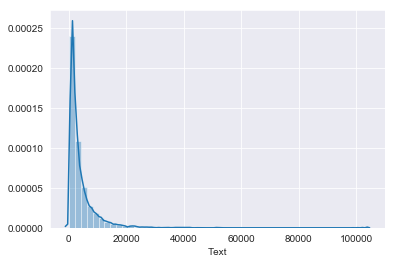

In [48]:
import seaborn as sns

sns.set_style('darkgrid')
sns.distplot(df2['Text'].apply(lambda x: len(x.split(' '))))

In [28]:
X = df2.Text
y = df2.Label

In [25]:
print(df2.Text)

0        line george orwells novel 1984 predicts power ...
1        maine legislature candidate leslie gibson insu...
2        17yearold girl named alyssa carson trained nas...
3        1988 author roald dahl penned open letter urgi...
4        comes fighting terrorism another thing know wo...
5        rhode island almost dead last among northeaste...
6        poorest counties us appalachia happen 90 perce...
7        koch industries paid legal fees george zimmerm...
8        minnesota michigan iowa already 70 mph speed l...
9        fbi uniform crime report 2016 shows four times...
10       pelosi sinks new low tells dems lie voters win...
11       socialist teachers south charlotte middle scho...
12       says us capitol stephen f austins sam houstons...
13       nasa confirmed earth new moonanother moon eart...
14       always going need architects doctors going nee...
15       justin amash rated michigans 1 conservative na...
16       breaking nfl owner listens trump fires player .

In [24]:
print(df2["Text"].values[0:5])
print(df2["Label"].values[0:5])

['line george orwells novel 1984 predicts power smartphones1984 george orwell predicted 2017 almost 70 years ago april 1984 13 00 comrade 6079 winston smith thinks thought starts diary falls love big brother always watching set world invasive government keeps malevolently watchful eye citizens radical much lauded staging explores surveillance identity orwell vision future relevant ever brand new australian cast bring adapter directors robert icke duncan macmillan thrilling vision back australia national tour crystal ball religious apparitions voices dead george orwell wrote nineteen eighty four accurately depicted present almost 70 years ago coincidence orwells 1949 novel climbed back multiple bestseller lists year people realised scarily accurate foretelling 2013 relevance still strong worryingly reliable led west end smash hit adaptation book currently showing australia book one greatest dystopian novels every written looks future people controlled think act live government known big

In [26]:
from sklearn.model_selection import train_test_split

In [29]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

#X_train, X_test, y_train, y_test = train_test_split(df2["Text"].values, df2["Label"].values, test_size=0.3, random_state=42)

In [30]:
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(10888,) (4667,) (10888,) (4667,)


# Naive Bayes Classifier

In [32]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfTransformer

nb = Pipeline([('vect', CountVectorizer()),
               ('tfidf', TfidfTransformer()),
               ('clf', MultinomialNB()),
              ])
nb.fit(X_train, y_train)

#%%time
from sklearn.metrics import classification_report
y_pred = nb.predict(X_test)

accuracy 0.5804585386758089


NameError: name 'my_tags' is not defined

In [33]:
print('accuracy %s' % accuracy_score(y_pred, y_test))
print(classification_report(y_test, y_pred))

accuracy 0.5804585386758089
              precision    recall  f1-score   support

           0       0.56      0.85      0.68      2228
           1       0.63      0.42      0.50      1934
           2       0.00      0.00      0.00       505

   micro avg       0.58      0.58      0.58      4667
   macro avg       0.40      0.42      0.39      4667
weighted avg       0.53      0.58      0.53      4667



C:\Users\Faizan\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [ ]:
confusion_matrix(y_test, y_pred)

In [ ]:
### The accuracy is 0.5804585386758089

# SVM (Support Vector Machine) Classifier

In [34]:
from sklearn.linear_model import SGDClassifier

sgd = Pipeline([('vect', CountVectorizer()),
                ('tfidf', TfidfTransformer()),
                ('clf', SGDClassifier(loss='hinge', penalty='l2',alpha=1e-3, random_state=42, max_iter=5, tol=None)),
               ])
sgd.fit(X_train, y_train)

#%%time

C:\Users\Faizan\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)
UsageError: Line magic function `%%time` not found.


In [35]:
y_pred = sgd.predict(X_test)

In [37]:
print('accuracy %s' % accuracy_score(y_pred, y_test))
print(classification_report(y_test, y_pred))

accuracy 0.6076708806513821
              precision    recall  f1-score   support

           0       0.60      0.79      0.68      2228
           1       0.62      0.55      0.58      1934
           2       0.00      0.00      0.00       505

   micro avg       0.61      0.61      0.61      4667
   macro avg       0.41      0.45      0.42      4667
weighted avg       0.54      0.61      0.57      4667



In [ ]:
confusion_matrix(y_test, y_pred)

In [ ]:
### The accuracy is 0.6076708806513821

# Logistic Regression (Just for good measure)

In [38]:
from sklearn.linear_model import LogisticRegression

logreg = Pipeline([('vect', CountVectorizer()),
                ('tfidf', TfidfTransformer()),
                ('clf', LogisticRegression(n_jobs=1, C=1e5)),
               ])
logreg.fit(X_train, y_train)

#%%time

y_pred = logreg.predict(X_test)

C:\Users\Faizan\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Faizan\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
C:\Users\Faizan\Anaconda3\lib\site-packages\sklearn\svm\base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


In [39]:
print('accuracy %s' % accuracy_score(y_pred, y_test))
print(classification_report(y_test, y_pred))

accuracy 0.566745232483394
              precision    recall  f1-score   support

           0       0.62      0.65      0.64      2228
           1       0.55      0.57      0.56      1934
           2       0.24      0.15      0.18       505

   micro avg       0.57      0.57      0.57      4667
   macro avg       0.47      0.46      0.46      4667
weighted avg       0.55      0.57      0.56      4667



In [ ]:
confusion_matrix(y_test, y_pred)

In [ ]:
# The accuracy is 0.566745232483394

# Word2vec and Logistic Regression (not completed)

In [ ]:
from gensim.models import Word2Vec
wv = gensim.models.KeyedVectors.load_word2vec_format("GoogleNews-vectors-negative300.bin.gz", binary=True)
wv.init_sims(replace=True)

In [ ]:
from itertools import islice
list(islice(wv.vocab, 13030, 13050))

In [ ]:
def w2v_tokenize_text(text):
    tokens = []
    for sent in nltk.sent_tokenize(text, language='english'):
        for word in nltk.word_tokenize(sent, language='english'):
            if len(word) < 2:
                continue
            tokens.append(word)
    return tokens
    
train, test = train_test_split(df2, test_size=0.3, random_state = 42)

test_tokenized = test.apply(lambda r: w2v_tokenize_text(r['Text']), axis=1).values
train_tokenized = train.apply(lambda r: w2v_tokenize_text(r['Text']), axis=1).values

X_train_word_average = word_averaging_list(wv,train_tokenized)
X_test_word_average = word_averaging_list(wv,test_tokenized)

# Doc2vec and Logistic Regression

In [63]:
from tqdm import tqdm
tqdm.pandas(desc="progress-bar")
from gensim.models import Doc2Vec
from sklearn import utils
import gensim
from gensim.models.doc2vec import TaggedDocument
import re

def label_sentences(corpus, label_type):
    """
    Gensim's Doc2Vec implementation requires each document/paragraph to have a label associated with it.
    We do this by using the TaggedDocument method. The format will be "TRAIN_i" or "TEST_i" where "i" is
    a dummy index of the post.
    """
    labeled = []
    for i, v in enumerate(corpus):
        label = label_type + '_' + str(i)
        labeled.append(TaggedDocument(v.split(), [label]))
    return labeled
X_train, X_test, y_train, y_test = train_test_split(df2.Text, df2.Label, random_state=0, test_size=0.3)
X_train = label_sentences(X_train, 'Train')
X_test = label_sentences(X_test, 'Test')
all_data = X_train + X_test

In [64]:
all_data[:2]

[TaggedDocument(words=['chip', 'always', 'bipartisan', 'support', 'year', 'let', 'money', 'expire', 'work', 'getting', 'tax', 'cuts', 'billionaire', 'millionaire', 'donorsclintons', 'claim', 'working', 'democrats', 'republicans', 'create', 'child', 'health', 'program', 'always', 'kids', 'millions', 'could', 'get', 'health', 'care', 'first', 'lady', 'worked', 'democrats', 'republicans', 'fix', 'creating', 'childrens', 'health', 'insurance', 'program', 'every', 'child', 'gets', 'health', 'care', 'deserve', '8', 'million', 'kids', 'covered', 'thats', 'kind', 'leader', 'kind', 'president', 'voiceover', 'hillary', 'clinton', 'campaign', 'ad', 'released', 'june', '15', 'new', 'ad', 'features', '1998', 'clip', 'hillary', 'clinton', 'speaking', 'childrens', 'health', 'insurance', 'program', 'chip', 'signed', 'law', 'husband', 'president', 'bill', 'clinton', 'ad', 'interesting', 'example', 'images', 'words', 'assembled', 'present', 'image', 'leadership', 'giving', 'misleading', 'impression', 'e

In [76]:
model_dbow = Doc2Vec(dm=0, vector_size=300, negative=5, min_count=1, alpha=0.065, min_alpha=0.065)
model_dbow.build_vocab([x for x in tqdm(all_data)])

# range(2) should actually be more like 30 but to save computational time used 3. 
for epoch in range(3): 
    model_dbow.train(utils.shuffle([x for x in tqdm(all_data)]), total_examples=len(all_data), epochs=1)
    model_dbow.alpha -= 0.002
    model_dbow.min_alpha = model_dbow.alpha

100%|█████████████████| 15555/15555 [00:00<00:00, 495394.00it/s]


In [77]:
def get_vectors(model, corpus_size, vectors_size, vectors_type):
    """
    Get vectors from trained doc2vec model
    :param doc2vec_model: Trained Doc2Vec model
    :param corpus_size: Size of the data
    :param vectors_size: Size of the embedding vectors
    :param vectors_type: Training or Testing vectors
    :return: list of vectors
    """
    vectors = np.zeros((corpus_size, vectors_size))
    for i in range(0, corpus_size):
        prefix = vectors_type + '_' + str(i)
        vectors[i] = model.docvecs[prefix]
    return vectors
    
train_vectors_dbow = get_vectors(model_dbow, len(X_train), 300, 'Train')
test_vectors_dbow = get_vectors(model_dbow, len(X_test), 300, 'Test')

In [78]:
logreg = LogisticRegression(n_jobs=1, C=1e5)
logreg.fit(train_vectors_dbow, y_train)
logreg = logreg.fit(train_vectors_dbow, y_train)
y_pred = logreg.predict(test_vectors_dbow)


C:\Users\Faizan\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Faizan\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
C:\Users\Faizan\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Faizan\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


accuracy 0.567173773301907


NameError: name 'my_tags' is not defined

In [79]:
print('accuracy %s' % accuracy_score(y_pred, y_test))
print(classification_report(y_test, y_pred))

accuracy 0.567173773301907
              precision    recall  f1-score   support

           0       0.60      0.65      0.62      2231
           1       0.54      0.62      0.57      1920
           2       0.25      0.01      0.02       516

   micro avg       0.57      0.57      0.57      4667
   macro avg       0.46      0.43      0.41      4667
weighted avg       0.53      0.57      0.54      4667



In [ ]:
confusion_matrix(y_test, y_pred)

In [ ]:
# The accuracy of the model is 0.567173773301907. 

# Neural Net for Text Classification

In [93]:
import itertools
import os

%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf

from sklearn.preprocessing import LabelBinarizer, LabelEncoder
from sklearn.metrics import confusion_matrix

from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout
from keras.preprocessing import text, sequence
from keras import utils

train_size = int(len(df2) * .7)
train_posts = df['Text'][:train_size]
train_tags = df['Label'][:train_size]

test_posts = df['Text'][train_size:]
test_tags = df['Label'][train_size:]

max_words = 6000
tokenize = text.Tokenizer(num_words=max_words, char_level=False)
tokenize.fit_on_texts(train_posts) # only fit on train

x_train = tokenize.texts_to_matrix(train_posts)
x_test = tokenize.texts_to_matrix(test_posts)


In [94]:
print(x_train.shape, x_test.shape)

(10888, 6000) (4667, 6000)


In [95]:
x_train[0:4]
len(x_train[0])

6000

In [96]:
len(x_train[0]), len(x_train[1]), len(x_train[2])

(6000, 6000, 6000)

In [97]:
encoder = LabelEncoder()
encoder.fit(train_tags)
y_train = encoder.transform(train_tags)
y_test = encoder.transform(test_tags)

In [98]:
num_classes = np.max(y_train) + 1
y_train = utils.to_categorical(y_train, num_classes)
y_test = utils.to_categorical(y_test, num_classes)



In [99]:
batch_size = 32
epochs = 5

# Build the model
model = Sequential()
model.add(Dense(512, input_shape=(max_words,)))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes))
model.add(Activation('softmax'))

model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
              
history = model.fit(x_train, y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    validation_split=0.1)

Train on 9799 samples, validate on 1089 samples
Epoch 1/5


5888/9799 [=================>............] - ETA: 1:45 - loss: 1.1267 - accuracy: 0.28 - ETA: 1:02 - loss: 1.2220 - accuracy: 0.42 - ETA: 49s - loss: 1.2437 - accuracy: 0.4479 - ETA: 44s - loss: 1.2922 - accuracy: 0.445 - ETA: 40s - loss: 1.3200 - accuracy: 0.456 - ETA: 38s - loss: 1.3694 - accuracy: 0.453 - ETA: 36s - loss: 1.3734 - accuracy: 0.442 - ETA: 34s - loss: 1.3755 - accuracy: 0.464 - ETA: 33s - loss: 1.4800 - accuracy: 0.447 - ETA: 31s - loss: 1.4382 - accuracy: 0.456 - ETA: 31s - loss: 1.4237 - accuracy: 0.454 - ETA: 30s - loss: 1.4476 - accuracy: 0.460 - ETA: 30s - loss: 1.5281 - accuracy: 0.459 - ETA: 29s - loss: 1.5069 - accuracy: 0.464 - ETA: 29s - loss: 1.5173 - accuracy: 0.464 - ETA: 28s - loss: 1.4878 - accuracy: 0.468 - ETA: 28s - loss: 1.4734 - accuracy: 0.468 - ETA: 28s - loss: 1.4780 - accuracy: 0.470 - ETA: 29s - loss: 1.4856 - accuracy: 0.477 - ETA: 29s - loss: 1.4658 - accuracy: 0.481 - ETA: 29s - loss: 1.4649 - accuracy: 0.480 - ETA: 29s - loss: 1.4638 - accu

9799/9799 [==============================] - ETA: 15s - loss: 1.0240 - accuracy: 0.560 - ETA: 14s - loss: 1.0224 - accuracy: 0.561 - ETA: 14s - loss: 1.0214 - accuracy: 0.561 - ETA: 14s - loss: 1.0203 - accuracy: 0.561 - ETA: 14s - loss: 1.0188 - accuracy: 0.562 - ETA: 14s - loss: 1.0184 - accuracy: 0.562 - ETA: 14s - loss: 1.0176 - accuracy: 0.562 - ETA: 14s - loss: 1.0168 - accuracy: 0.562 - ETA: 13s - loss: 1.0156 - accuracy: 0.562 - ETA: 13s - loss: 1.0156 - accuracy: 0.562 - ETA: 13s - loss: 1.0156 - accuracy: 0.563 - ETA: 13s - loss: 1.0143 - accuracy: 0.564 - ETA: 13s - loss: 1.0140 - accuracy: 0.563 - ETA: 13s - loss: 1.0135 - accuracy: 0.564 - ETA: 13s - loss: 1.0131 - accuracy: 0.564 - ETA: 12s - loss: 1.0118 - accuracy: 0.564 - ETA: 12s - loss: 1.0104 - accuracy: 0.565 - ETA: 12s - loss: 1.0100 - accuracy: 0.565 - ETA: 12s - loss: 1.0087 - accuracy: 0.565 - ETA: 12s - loss: 1.0084 - accuracy: 0.565 - ETA: 12s - loss: 1.0084 - accuracy: 0.566 - ETA: 12s - loss: 1.0079 - accur

5952/9799 [=================>............] - ETA: 23s - loss: 0.8103 - accuracy: 0.625 - ETA: 23s - loss: 0.8561 - accuracy: 0.562 - ETA: 24s - loss: 0.8708 - accuracy: 0.562 - ETA: 25s - loss: 0.8731 - accuracy: 0.578 - ETA: 24s - loss: 0.8607 - accuracy: 0.600 - ETA: 24s - loss: 0.8747 - accuracy: 0.588 - ETA: 26s - loss: 0.8771 - accuracy: 0.589 - ETA: 25s - loss: 0.8694 - accuracy: 0.605 - ETA: 25s - loss: 0.8617 - accuracy: 0.614 - ETA: 25s - loss: 0.8477 - accuracy: 0.621 - ETA: 24s - loss: 0.8402 - accuracy: 0.627 - ETA: 24s - loss: 0.8294 - accuracy: 0.635 - ETA: 24s - loss: 0.8464 - accuracy: 0.622 - ETA: 24s - loss: 0.8461 - accuracy: 0.622 - ETA: 24s - loss: 0.8462 - accuracy: 0.618 - ETA: 24s - loss: 0.8467 - accuracy: 0.623 - ETA: 24s - loss: 0.8424 - accuracy: 0.626 - ETA: 24s - loss: 0.8400 - accuracy: 0.630 - ETA: 24s - loss: 0.8408 - accuracy: 0.634 - ETA: 24s - loss: 0.8289 - accuracy: 0.639 - ETA: 24s - loss: 0.8352 - accuracy: 0.636 - ETA: 24s - loss: 0.8283 - accur

9799/9799 [==============================] - ETA: 12s - loss: 0.8115 - accuracy: 0.648 - ETA: 12s - loss: 0.8127 - accuracy: 0.647 - ETA: 12s - loss: 0.8126 - accuracy: 0.647 - ETA: 12s - loss: 0.8133 - accuracy: 0.647 - ETA: 12s - loss: 0.8129 - accuracy: 0.646 - ETA: 12s - loss: 0.8125 - accuracy: 0.647 - ETA: 11s - loss: 0.8123 - accuracy: 0.648 - ETA: 11s - loss: 0.8125 - accuracy: 0.647 - ETA: 11s - loss: 0.8120 - accuracy: 0.648 - ETA: 11s - loss: 0.8121 - accuracy: 0.648 - ETA: 11s - loss: 0.8116 - accuracy: 0.647 - ETA: 11s - loss: 0.8119 - accuracy: 0.647 - ETA: 11s - loss: 0.8123 - accuracy: 0.647 - ETA: 11s - loss: 0.8132 - accuracy: 0.647 - ETA: 11s - loss: 0.8141 - accuracy: 0.646 - ETA: 10s - loss: 0.8136 - accuracy: 0.647 - ETA: 10s - loss: 0.8138 - accuracy: 0.646 - ETA: 10s - loss: 0.8145 - accuracy: 0.645 - ETA: 10s - loss: 0.8148 - accuracy: 0.645 - ETA: 10s - loss: 0.8159 - accuracy: 0.644 - ETA: 10s - loss: 0.8156 - accuracy: 0.644 - ETA: 10s - loss: 0.8159 - accur

5952/9799 [=================>............] - ETA: 50s - loss: 0.7858 - accuracy: 0.687 - ETA: 50s - loss: 0.7546 - accuracy: 0.656 - ETA: 51s - loss: 0.7570 - accuracy: 0.656 - ETA: 48s - loss: 0.7449 - accuracy: 0.664 - ETA: 44s - loss: 0.7539 - accuracy: 0.650 - ETA: 42s - loss: 0.7357 - accuracy: 0.671 - ETA: 43s - loss: 0.7714 - accuracy: 0.651 - ETA: 44s - loss: 0.7583 - accuracy: 0.671 - ETA: 44s - loss: 0.7433 - accuracy: 0.673 - ETA: 46s - loss: 0.7468 - accuracy: 0.668 - ETA: 46s - loss: 0.7466 - accuracy: 0.667 - ETA: 47s - loss: 0.7496 - accuracy: 0.674 - ETA: 46s - loss: 0.7404 - accuracy: 0.682 - ETA: 45s - loss: 0.7297 - accuracy: 0.687 - ETA: 43s - loss: 0.7397 - accuracy: 0.675 - ETA: 42s - loss: 0.7311 - accuracy: 0.685 - ETA: 42s - loss: 0.7362 - accuracy: 0.682 - ETA: 41s - loss: 0.7398 - accuracy: 0.682 - ETA: 40s - loss: 0.7358 - accuracy: 0.685 - ETA: 39s - loss: 0.7318 - accuracy: 0.687 - ETA: 39s - loss: 0.7228 - accuracy: 0.694 - ETA: 39s - loss: 0.7210 - accur

9799/9799 [==============================] - ETA: 14s - loss: 0.7244 - accuracy: 0.685 - ETA: 14s - loss: 0.7242 - accuracy: 0.685 - ETA: 13s - loss: 0.7246 - accuracy: 0.684 - ETA: 13s - loss: 0.7238 - accuracy: 0.685 - ETA: 13s - loss: 0.7238 - accuracy: 0.685 - ETA: 13s - loss: 0.7240 - accuracy: 0.685 - ETA: 13s - loss: 0.7238 - accuracy: 0.685 - ETA: 13s - loss: 0.7230 - accuracy: 0.685 - ETA: 13s - loss: 0.7229 - accuracy: 0.685 - ETA: 13s - loss: 0.7228 - accuracy: 0.685 - ETA: 12s - loss: 0.7228 - accuracy: 0.685 - ETA: 12s - loss: 0.7236 - accuracy: 0.684 - ETA: 12s - loss: 0.7229 - accuracy: 0.685 - ETA: 12s - loss: 0.7225 - accuracy: 0.685 - ETA: 12s - loss: 0.7214 - accuracy: 0.685 - ETA: 12s - loss: 0.7219 - accuracy: 0.685 - ETA: 12s - loss: 0.7234 - accuracy: 0.684 - ETA: 12s - loss: 0.7234 - accuracy: 0.684 - ETA: 11s - loss: 0.7227 - accuracy: 0.684 - ETA: 11s - loss: 0.7225 - accuracy: 0.684 - ETA: 11s - loss: 0.7219 - accuracy: 0.684 - ETA: 11s - loss: 0.7223 - accur

5952/9799 [=================>............] - ETA: 28s - loss: 0.7035 - accuracy: 0.656 - ETA: 27s - loss: 0.6808 - accuracy: 0.687 - ETA: 27s - loss: 0.6891 - accuracy: 0.697 - ETA: 27s - loss: 0.6394 - accuracy: 0.726 - ETA: 27s - loss: 0.6529 - accuracy: 0.718 - ETA: 26s - loss: 0.6299 - accuracy: 0.739 - ETA: 26s - loss: 0.6528 - accuracy: 0.714 - ETA: 26s - loss: 0.6691 - accuracy: 0.707 - ETA: 26s - loss: 0.6580 - accuracy: 0.715 - ETA: 26s - loss: 0.6591 - accuracy: 0.715 - ETA: 26s - loss: 0.6621 - accuracy: 0.713 - ETA: 26s - loss: 0.6505 - accuracy: 0.724 - ETA: 26s - loss: 0.6445 - accuracy: 0.723 - ETA: 26s - loss: 0.6343 - accuracy: 0.727 - ETA: 26s - loss: 0.6273 - accuracy: 0.729 - ETA: 26s - loss: 0.6267 - accuracy: 0.730 - ETA: 26s - loss: 0.6150 - accuracy: 0.739 - ETA: 26s - loss: 0.6118 - accuracy: 0.741 - ETA: 25s - loss: 0.6024 - accuracy: 0.750 - ETA: 25s - loss: 0.5899 - accuracy: 0.759 - ETA: 25s - loss: 0.5850 - accuracy: 0.761 - ETA: 25s - loss: 0.5883 - accur

9799/9799 [==============================] - ETA: 11s - loss: 0.6082 - accuracy: 0.740 - ETA: 11s - loss: 0.6081 - accuracy: 0.740 - ETA: 11s - loss: 0.6078 - accuracy: 0.740 - ETA: 11s - loss: 0.6094 - accuracy: 0.740 - ETA: 11s - loss: 0.6102 - accuracy: 0.740 - ETA: 11s - loss: 0.6110 - accuracy: 0.739 - ETA: 11s - loss: 0.6102 - accuracy: 0.740 - ETA: 11s - loss: 0.6109 - accuracy: 0.739 - ETA: 10s - loss: 0.6112 - accuracy: 0.739 - ETA: 10s - loss: 0.6107 - accuracy: 0.740 - ETA: 10s - loss: 0.6111 - accuracy: 0.739 - ETA: 10s - loss: 0.6113 - accuracy: 0.739 - ETA: 10s - loss: 0.6110 - accuracy: 0.740 - ETA: 10s - loss: 0.6116 - accuracy: 0.739 - ETA: 10s - loss: 0.6115 - accuracy: 0.739 - ETA: 10s - loss: 0.6120 - accuracy: 0.739 - ETA: 10s - loss: 0.6124 - accuracy: 0.738 - ETA: 9s - loss: 0.6125 - accuracy: 0.738 - ETA: 9s - loss: 0.6133 - accuracy: 0.73 - ETA: 9s - loss: 0.6148 - accuracy: 0.73 - ETA: 9s - loss: 0.6139 - accuracy: 0.73 - ETA: 9s - loss: 0.6136 - accuracy: 0.7

5952/9799 [=================>............] - ETA: 24s - loss: 0.4145 - accuracy: 0.843 - ETA: 28s - loss: 0.4222 - accuracy: 0.843 - ETA: 28s - loss: 0.4161 - accuracy: 0.833 - ETA: 27s - loss: 0.4283 - accuracy: 0.820 - ETA: 27s - loss: 0.4217 - accuracy: 0.825 - ETA: 27s - loss: 0.4336 - accuracy: 0.828 - ETA: 26s - loss: 0.4467 - accuracy: 0.817 - ETA: 27s - loss: 0.4554 - accuracy: 0.820 - ETA: 27s - loss: 0.4493 - accuracy: 0.822 - ETA: 27s - loss: 0.4448 - accuracy: 0.825 - ETA: 26s - loss: 0.4370 - accuracy: 0.823 - ETA: 26s - loss: 0.4502 - accuracy: 0.817 - ETA: 26s - loss: 0.4711 - accuracy: 0.812 - ETA: 26s - loss: 0.4698 - accuracy: 0.814 - ETA: 26s - loss: 0.4825 - accuracy: 0.802 - ETA: 25s - loss: 0.4820 - accuracy: 0.800 - ETA: 25s - loss: 0.4804 - accuracy: 0.807 - ETA: 25s - loss: 0.4897 - accuracy: 0.802 - ETA: 25s - loss: 0.4876 - accuracy: 0.801 - ETA: 25s - loss: 0.4870 - accuracy: 0.803 - ETA: 25s - loss: 0.4856 - accuracy: 0.803 - ETA: 25s - loss: 0.4806 - accur

9799/9799 [==============================] - ETA: 11s - loss: 0.4910 - accuracy: 0.801 - ETA: 11s - loss: 0.4906 - accuracy: 0.801 - ETA: 11s - loss: 0.4903 - accuracy: 0.801 - ETA: 11s - loss: 0.4914 - accuracy: 0.801 - ETA: 10s - loss: 0.4914 - accuracy: 0.800 - ETA: 10s - loss: 0.4915 - accuracy: 0.800 - ETA: 10s - loss: 0.4931 - accuracy: 0.800 - ETA: 10s - loss: 0.4932 - accuracy: 0.800 - ETA: 10s - loss: 0.4933 - accuracy: 0.800 - ETA: 10s - loss: 0.4929 - accuracy: 0.800 - ETA: 10s - loss: 0.4935 - accuracy: 0.800 - ETA: 10s - loss: 0.4948 - accuracy: 0.799 - ETA: 10s - loss: 0.4947 - accuracy: 0.799 - ETA: 10s - loss: 0.4947 - accuracy: 0.799 - ETA: 9s - loss: 0.4941 - accuracy: 0.800 - ETA: 9s - loss: 0.4945 - accuracy: 0.80 - ETA: 9s - loss: 0.4955 - accuracy: 0.79 - ETA: 9s - loss: 0.4956 - accuracy: 0.79 - ETA: 9s - loss: 0.4956 - accuracy: 0.79 - ETA: 9s - loss: 0.4964 - accuracy: 0.79 - ETA: 9s - loss: 0.4969 - accuracy: 0.79 - ETA: 9s - loss: 0.4970 - accuracy: 0.79 - ET

In [100]:
score = model.evaluate(x_test, y_test,
                       batch_size=batch_size, verbose=1)


4667/4667 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 3s 559us/step


In [101]:
print('Test accuracy:', score[1]) # The accuracy of the test data

Test accuracy: 0.6175273060798645


In [102]:
print(score[0]) # The loss of the test data

0.9483548373156347


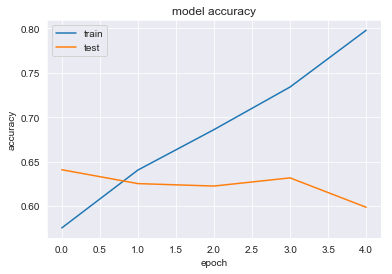

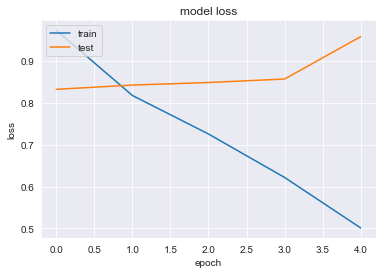

In [104]:
# Plotting the loss and accuracy

# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [88]:
# Test model accuracy for max_words = 6000 is 0.6175273060798645

In [ ]:
# Test model accuracy for max_words = 1000 is 0.5913863182067871